In [3]:
# Imports necessários
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
import matplotlib.pyplot as plt

In [4]:
# Carregar o dataset de vinhos a partir da URL
url = "https://raw.githubusercontent.com/klaytoncastro/idp-machinelearning/main/decision-tree/winequality-merged.csv"
data = pd.read_csv(url)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [5]:
# Substituindo a variável categórica por numérica
data['color'] = data['color'].replace('red', 0)
data['color'] = data['color'].replace('white', 1)
# Definindo o limiar para corte de vinhos bons como os de qualidade >=7
data['worst'] = np.where(data['quality'] < 7, 1, 0)
data = data.drop(['quality'], axis=1)
data.head()

<ipython-input-5-b3b25f1513fc>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['color'] = data['color'].replace('white', 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,worst
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1


In [7]:
# Exibir o percentual de cada classe
print(data['worst'].value_counts(normalize=True) * 100)

# Separar os recursos (features) da variável alvo (target)
X = data.drop('worst', axis=1)
y = data['worst']

# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definindo o modelo ExtraTreesClassifier
model = ExtraTreesClassifier()

worst
1    80.344775
0    19.655225
Name: proportion, dtype: float64


In [8]:
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [10]:
# Aplicando o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Treinando o modelo com Randomized Search
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
96 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
62 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, verbose=2)

In [11]:
# Prevendo as probabilidades no conjunto de teste
y_probs = random_search.best_estimator_.predict_proba(X_test)[:, 1]

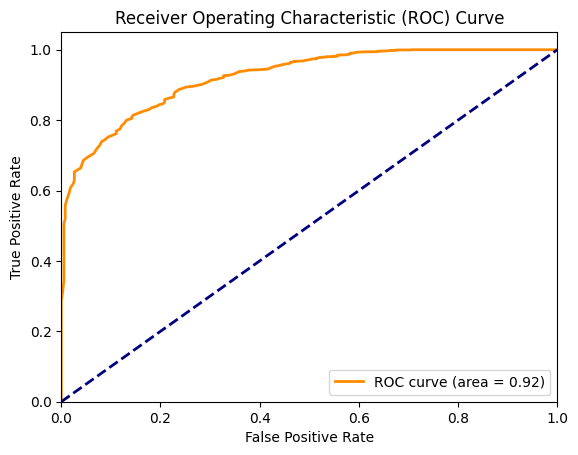

In [12]:
# Gerando a curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Exibindo os melhores parâmetros encontrados
print("Melhores parâmetros encontrados: ", random_search.best_params_)

Melhores parâmetros encontrados:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [16]:
# Testar o modelo otimizado no conjunto de teste
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [17]:
"""
Calculando e exibindo a matriz de confusão. A orientação padrão é a seguinte:
[0,0]: Verdadeiros Negativos (VN) - Previsões corretamente identificadas como negativas.
[0,1]: Falsos Positivos (FP) - Previsões incorretamente identificadas como positivas.
[1,0]: Falsos Negativos (FN) - Previsões incorretamente identificadas como negativas.
[1,1]: Verdadeiros Positivos (VP) - Previsões corretamente identificadas como positivas.
"""

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[ 188  191]
 [  42 1529]]
